[0.25, 0.5, 0.75, 1.0]
0.04739145148528003 0.0007545409998783725
0.358574106213353 0.005836848000399186
0.5835256657090653 0.009916361999785295
0.7699293837776146 0.013985430000502674
0.9440747099988235 0.019652087000395113
0.9977147183054682 0.023923812999782967
0.9832849471429376 0.02791404199979297
0.8890262738895964 0.03256912699998793
0.7146148059223733 0.03733009999996284
0.48676687742071245 0.041908805999810284
0.22923044716828617 0.04631895300008182
-0.011095123612225383 0.05017658799988567
-0.24164303627492956 0.053884314999777416
-0.5301368663394478 0.0588929730001837
-0.7536720806406759 0.06358596500012936
-0.9052161368044912 0.06801455799995892
-0.9878055782248901 0.07251195600019855
-0.9878849611199849 0.077479915999902
-0.9000259252171432 0.0821773679999751
-0.5964233648321516 0.08982939799989254
-0.3360248665653601 0.09454586900028517
-0.05706911953129494 0.09909122299995943
0.2376538847035869 0.10381891999986692
0.47883282977429115 0.10794700000042212
0.6865835501465054

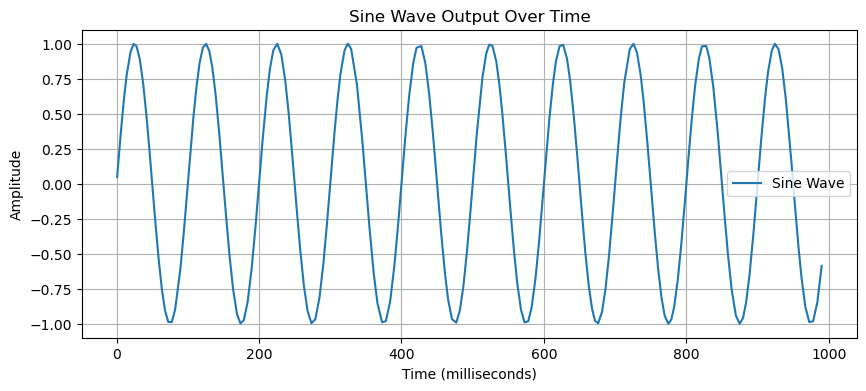

Finished generating the sine wave.


In [21]:
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt

class OscGenProcess:
    def __init__(self, amplitude, frequency, phase_shift, spk_threshold, duration=None):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase_shift = phase_shift
        self.duration = duration
        
        # Define thresholds where to send spikes
        num_steps = int(self.amplitude / (self.amplitude * spk_threshold))  # Number of thresholds
        self.thresholds = [self.amplitude * spk_threshold * i for i in range(1, num_steps + 1)]
        self.current_threshold_index = 0
        self.last_y = 0
        self.omega = 2 * np.pi * self.frequency

        # Initializing manager and shared lists correctly
        manager = multiprocessing.Manager()
        self.times = manager.list()
        self.outputs = manager.list()

        # Event for controlling the indefinite run
        self.stop_event = manager.Event()

    def generate_sine_wave(self):
        print(self.thresholds)
        period = 1 / self.frequency
        # interval = period / 100
        start_time = time.perf_counter()
        max_list_size = 50000  # Maximum number of elements in the list

        if self.duration is not None:
            end_time = start_time + self.duration

        while not self.stop_event.is_set() and (self.duration is None or time.time() < end_time):
            current_time = time.perf_counter() - start_time
            y = self.amplitude * np.sin(self.omega * current_time + self.phase_shift)
            print(y, current_time)
            # Ensure list does not exceed the maximum size
            if len(self.times) >= max_list_size:
                # Remove the oldest item
                self.times.pop(0)
                self.outputs.pop(0)

            # Append current time and output to the lists
            self.times.append(current_time * 1000)  # Convert time to milliseconds
            self.outputs.append(y)

            #check for spike send
            #self.check_and_send_spike(y)
        
            #time.sleep(interval)

    def run(self):
        self.process = multiprocessing.Process(target=self.generate_sine_wave)
        self.process.start()

    def stop(self):
        self.stop_event.set()
        self.process.join()

    '''
    def check_and_send_spike(self, y):
        increasing = y > self.last_y
        if increasing and y >= self.thresholds[self.current_threshold_index]:
            self.send_spike(y)
            if self.current_threshold_index < len(self.thresholds) - 1:
                self.current_threshold_index += 1
        elif not increasing and y <= self.thresholds[self.current_threshold_index]:
            self.send_spike(y)
            if self.current_threshold_index > 0:
                self.current_threshold_index -= 1
        self.last_y = y

    def send_spike(self, y): # Updated to include y in the output
        print(f"Spike sent at y={y}, current threshold{self.current_threshold_index}")
    '''
    def plot_results(self):
        plt.figure(figsize=(10, 4))
        plt.plot(list(self.times), list(self.outputs), label='Sine Wave')  # Convert Manager list to regular list
        plt.title('Sine Wave Output Over Time')
        plt.xlabel('Time (milliseconds)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()


if __name__ == '__main__':
    oscillator = OscGenProcess(amplitude=1, frequency=10, phase_shift=0, spk_threshold=0.25)
    oscillator.run()  # Start generating in a separate process
    time.sleep(1)  # Let it run for 2 seconds
    oscillator.stop()  # Stop the generation
    oscillator.plot_results()
    print("Finished generating the sine wave.")

Below are the script to parse the C++ code found in `SineWaveGenerator.cpp`

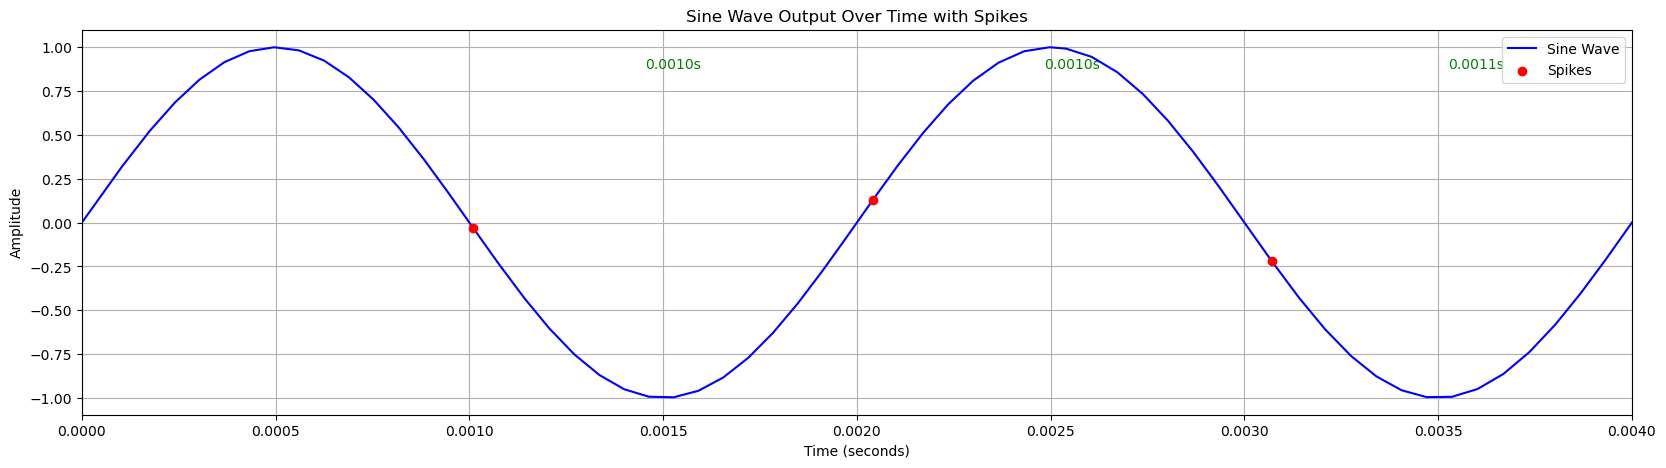

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from CSV
data = pd.read_csv('sine_wave_data.csv')

# Assuming the frequency of the sine wave is about 500 Hz
frequency = 500  # Hz
period = 1 / frequency  # Period of the sine wave in seconds

# Define time range for zooming, focusing on the first few milliseconds
# For example, visualize the first two periods of the sine wave
zoom_milliseconds = period * 2 * 1000  # Convert seconds to milliseconds for two periods

# Find the time range within the first few milliseconds
start_time = 0  # Start from the beginning of the data
end_time = start_time + zoom_milliseconds / 1000  # Convert back to seconds for the end time

# Plotting the sine wave
plt.figure(figsize=(20, 5))
plt.plot(data['Time'], data['Value'], label='Sine Wave', color='blue')

# Highlighting spikes
spike_data = data[data['SpikeSent'] == 1]
plt.scatter(spike_data['Time'], spike_data['Value'], color='red', label='Spikes', zorder=5)

# Calculate Δt between spikes and annotate on the plot
if not spike_data.empty:
    spike_times = spike_data['Time'].values
    delta_ts = np.diff(spike_times)  # numpy diff to find the time difference between consecutive spikes

    # Annotate Δt values between spikes on the plot
    for i in range(len(delta_ts)):
        # Position of the annotation in the middle of two spikes
        x_pos = (spike_times[i] + spike_times[i + 1]) / 2
        y_pos = max(data['Value']) * 0.8  # Positioning the text slightly below the top of the plot
        plt.annotate(f'{delta_ts[i]:.4f}s', (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center', color='green')

# Adding labels and title
plt.title('Sine Wave Output Over Time with Spikes')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Set x and y limits for zooming
plt.xlim(start_time, end_time)
# Optionally set y limits based on the max and min values in the zoom window
visible_data = data[(data['Time'] >= start_time) & (data['Time'] <= end_time)]
plt.ylim(visible_data['Value'].min() * 1.1, visible_data['Value'].max() * 1.1)

# Show the plot
plt.show()


In [24]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Load the data from CSV
data = pd.read_csv('sine_wave_data.csv')

# Plotting the sine wave
plt.figure(figsize=(20, 5))
plt.plot(data['Time'], data['Value'], label='Sine Wave', color='blue')

# Highlighting spikes
spike_data = data[data['SpikeSent'] == 1]
plt.scatter(spike_data['Time'], spike_data['Value'], color='red', label='Spikes', zorder=5)

# Calculate Δt between spikes and annotate on the plot with lines
if not spike_data.empty:
    spike_times = spike_data['Time'].values
    delta_ts = np.diff(spike_times)  # numpy diff to find the time difference between consecutive spikes

    # Annotate Δt values between spikes on the plot
    for i in range(len(delta_ts)):
        # Position of the annotation in the middle of two spikes
        x_pos = (spike_times[i] + spike_times[i + 1]) / 2
        y_pos = max(data['Value']) * 0.95  # Positioning the text at the top of the plot
        plt.annotate(f'{delta_ts[i]:.4f}s', (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center', color='green')

        # Draw a vertical line for each spike and a horizontal line to show the interval
        plt.axvline(x=spike_times[i], color='grey', linestyle='--', linewidth=0.5)
        if i < len(delta_ts):  # Ensure there's a next spike to draw the line to
            plt.hlines(y=y_pos, xmin=spike_times[i], xmax=spike_times[i + 1], colors='grey', linestyles='solid', lw=2)
            plt.text((spike_times[i] + spike_times[i + 1])/2, y_pos, f'Δt={delta_ts[i]:.4f}s',
                     horizontalalignment='center', verticalalignment='bottom', color='black')

# Adding labels and title
plt.title('Sine Wave Output Over Time with Spikes')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


<IPython.core.display.Javascript object>